In [1]:
import sys
import importlib
# Make imports work
sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from colour import Color
from mhealth_anomaly_detection import anomaly_detection
from mhealth_anomaly_detection import format_axis as fa
from mhealth_anomaly_detection import load_refs as lr
from mhealth_anomaly_detection import plots

/Users/sakre/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
YEAR = 3
EXPERIMENT = 'exp06'
exp06_ad = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}_intermediate.csv')    
)
exp06 = pd.read_csv(
    Path('../cache', f'GLOBEM-{YEAR}_{EXPERIMENT}.csv')    
)

/var/folders/n5/2y22qmm94m583fwzs33kt5chmmbr8_/T/ipykernel_58217/377549443.py:3: DtypeWarning: Columns (372,373,374,375,376,377,378,379,380,381) have mixed types. Specify dtype option on import or set low_memory=False.
  exp06_ad = pd.read_csv(


In [4]:
exp06_ad.subject_id.nunique()

128

In [5]:
FEATURES = [
    'f_loc:phone_locations_doryab_locationentropy:allday',
    'f_loc:phone_locations_barnett_circdnrtn:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday',
    'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday',
    'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
    'f_call:phone_calls_rapids_missed_count:allday',
    'f_call:phone_calls_rapids_incoming_count:allday',
    'f_call:phone_calls_rapids_outgoing_count:allday',
    'f_call:phone_calls_rapids_outgoing_sumduration:allday',
    'sleep_missing',
    'steps_missing',
    'location_missing',
    'call_missing',
]
FEATURES = [c for c in FEATURES if c in exp06_ad.columns]

In [6]:
from mhealth_anomaly_detection import datasets
importlib.reload(datasets)
GLOBEM = datasets.GLOBEM(year=YEAR, load_data=False)
prepost = GLOBEM.get_pre_post_surveys()
phq4 = GLOBEM.get_weekly_phq4()

In [7]:
phq_std = pd.DataFrame(
    phq4.rename(columns={'pid':'subject_id'}).groupby('subject_id').phq4.std()
).reset_index().rename(columns={'phq4':'phq_std'})

In [8]:
surveys = [c.removesuffix('_CHANGE') for c in prepost.columns if c not in ['subject_id', 'pre_date', 'post_date'] and c.endswith('_CHANGE')]
surveys

['UCLA_10items',
 'SocialFit',
 '2waySSS_receiving_emotional',
 '2waySSS_giving_emotional',
 '2waySSS_giving_instrumental',
 '2waySSS_receiving_instrumental',
 'ERQ_reappraisal',
 'ERQ_suppression',
 'BRS',
 'CHIPS',
 'PSS_10items',
 'PSS_14items',
 'STAI',
 'MAAS_15items',
 'CESD_9items',
 'CESD_10items',
 'BDI2',
 'BriefCope_adaptive',
 'BriefCope_maladaptive',
 'GQ',
 'FSPWB',
 'EDS',
 'CEDH',
 'BYAACQ']

In [9]:
filt_06 = exp06_ad.merge(prepost).merge(phq_std)
filt_06 = filt_06[(filt_06.date >= filt_06.pre_date) & (filt_06.date <= filt_06.post_date)]
filt_06.shape, exp06_ad.shape

((87876, 462), (119466, 382))

<Axes: ylabel='subject_id'>

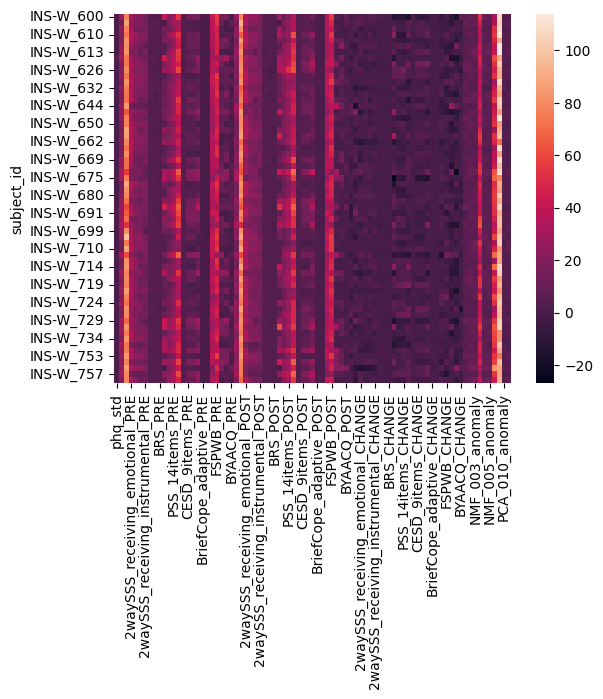

In [10]:
anomaly_detector_cols = [
    d for d in exp06_ad.columns if d.endswith("_anomaly")
]
survey_cols = [
    *[c + '_PRE' for c in surveys],
    *[c + '_POST' for c in surveys],
    *[c + '_CHANGE' for c in surveys]
]
study_level = filt_06.groupby([
    'subject_id',
    'phq_std',
    *survey_cols,
])[anomaly_detector_cols].sum().reset_index()
sns.heatmap(study_level.set_index('subject_id'))

In [11]:
corr_dfs = []
study_level['year'] = YEAR
study_level['study'] = 'GLOBEM'
for s in surveys:
    for target in ['CHANGE']:
        outcome_col = f'{s}_{target}'
        corr_df = anomaly_detection.correlateDetectedToOutcome(
            detected_anomalies=study_level,
            anomaly_detector_cols=anomaly_detector_cols,
            outcome_col=outcome_col,
            groupby_cols=['year', 'study']
        )
        corr_df['outcome'] = outcome_col
        corr_df['survey'] = s
        corr_df['target'] = target
        corr_dfs.append(corr_df)

corr_df = anomaly_detection.correlateDetectedToOutcome(
    detected_anomalies=study_level,
    anomaly_detector_cols=anomaly_detector_cols,
    outcome_col='phq_std',
    groupby_cols=['year', 'study']
)
corr_df['outcome'] = 'phq4_std'
corr_df['survey'] = 'phq4_std'
corr_df['target'] = 'CHANGE'
corr_dfs.append(corr_df)
study_corrs = pd.concat(corr_dfs)
study_corrs

,detector,rho,p,n,year,study,outcome,survey,target
0,RollingMean_anomaly,-0.175994,0.171222,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
1,PCA_003_anomaly,-0.137136,0.287844,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
2,NMF_003_anomaly,-0.137882,0.285204,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
3,SVM_poly_anomaly,-0.067179,0.603906,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
4,PCA_005_anomaly,-0.129575,0.315497,62,3,GLOBEM,UCLA_10items_CHANGE,UCLA_10items,CHANGE
...,...,...,...,...,...,...,...,...,...
5,NMF_005_anomaly,-0.074357,0.565716,62,3,GLOBEM,phq4_std,phq4_std,CHANGE
6,SVM_rbf_anomaly,0.195282,0.128248,62,3,GLOBEM,phq4_std,phq4_std,CHANGE
7,SVM_sigmoid_anomaly,0.021900,0.865835,62,3,GLOBEM,phq4_std,phq4_std,CHANGE
8,PCA_010_anomaly,0.019019,0.883355,62,3,GLOBEM,phq4_std,phq4_std,CHANGE


<Axes: xlabel='score_norm', ylabel='survey'>

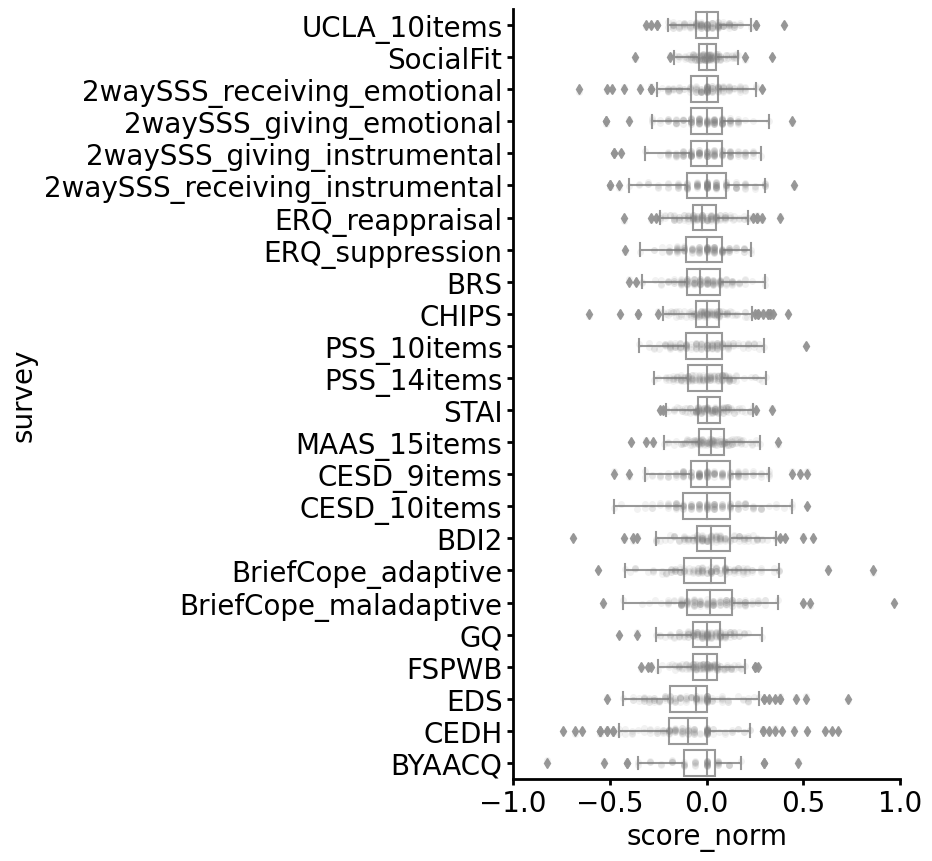

In [12]:
prepost_melt = prepost[['subject_id', *survey_cols]].melt(id_vars='subject_id', var_name='outcome', value_name='score')
prepost_melt['survey'] = prepost_melt['outcome'].str.split('_').str[:-1].str.join('_')
prepost_melt['target'] = prepost_melt['outcome'].str.split('_').str[-1]
survey_max = prepost_melt.groupby('survey').score.max().reset_index().rename(columns={'score': 'max_score'})
prepost_melt = prepost_melt.merge(survey_max)
prepost_melt['score_norm'] = prepost_melt['score']/prepost_melt['max_score']

fig, ax = plt.subplots(figsize=(5,10))
sns.stripplot(
    x='score_norm',
    y='survey',
    data=prepost_melt[prepost_melt.target == 'CHANGE'],
    alpha=.1,
    color='gray',
    ax=ax
)
sns.boxplot(
    x='score_norm',
    y='survey',
    data=prepost_melt[prepost_melt.target == 'CHANGE'],
    color='white',
    ax=ax
)
ax.set_xlim([-1, 1])
fa.despine_thicken_axes(ax, )

<Axes: xlabel='survey', ylabel='model'>

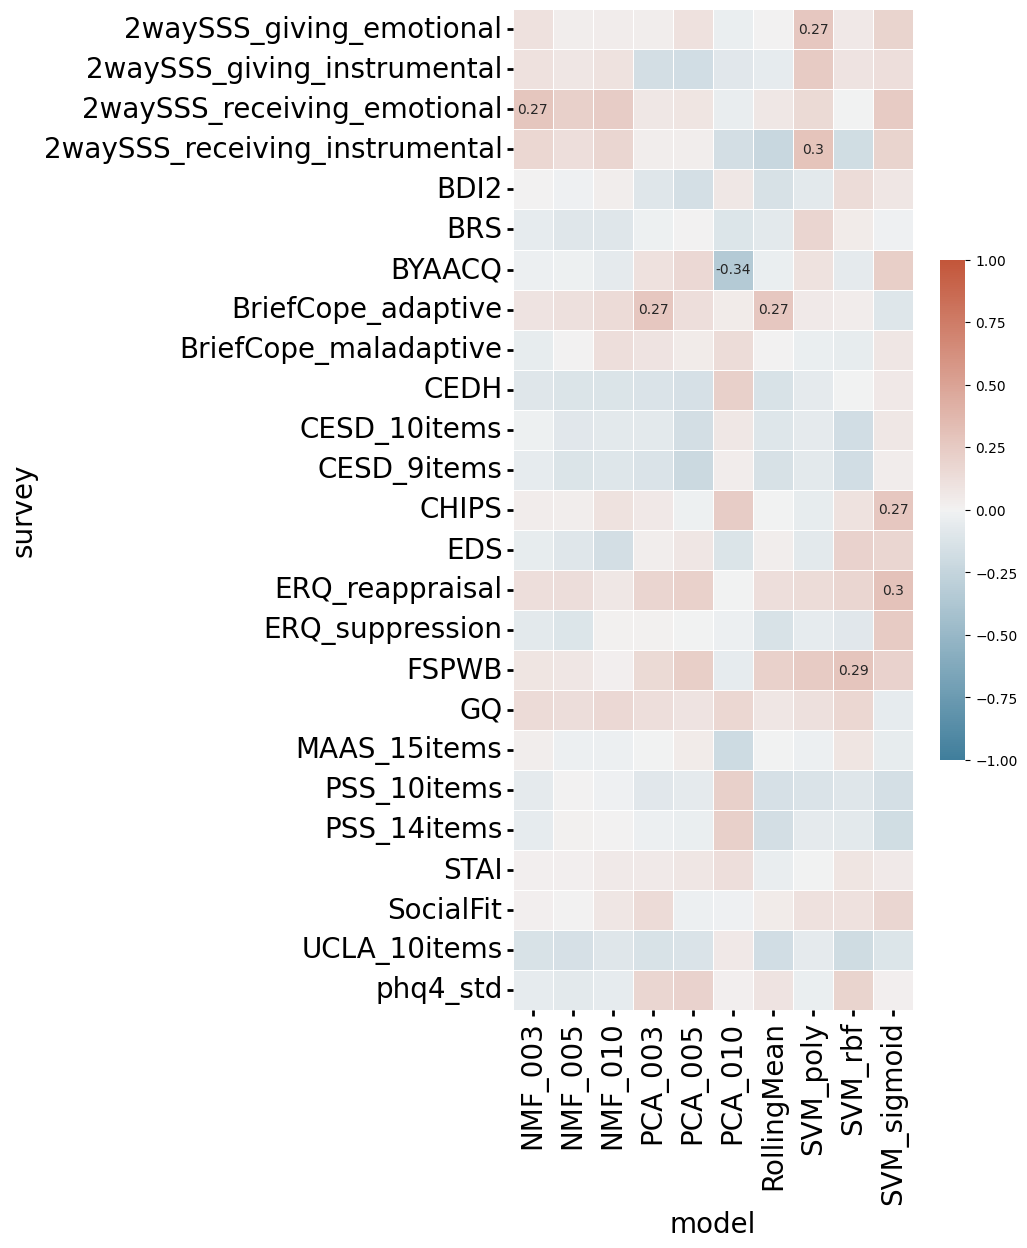

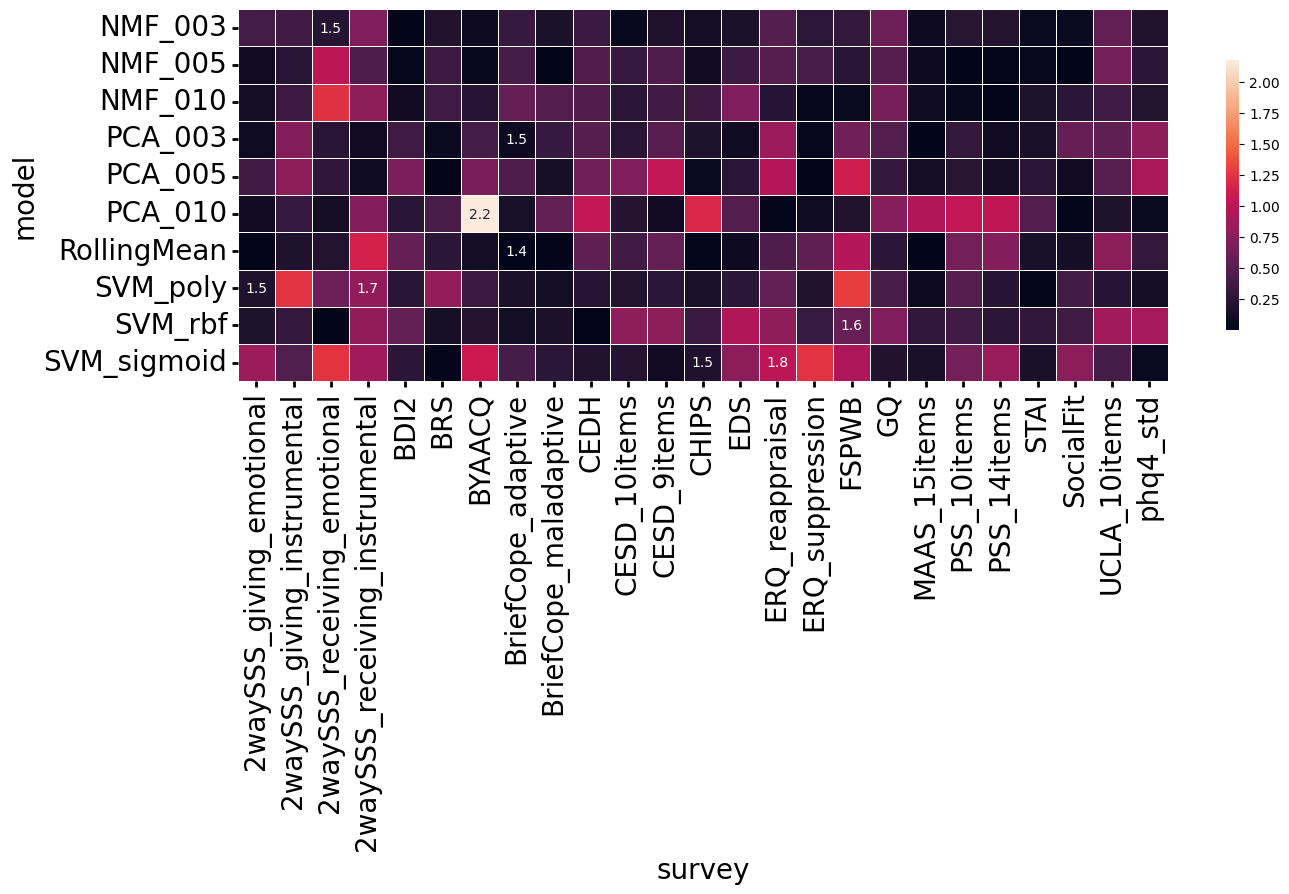

In [13]:
study_corrs['model'] = study_corrs.detector.str.removesuffix('_anomaly')
study_corr_piv = study_corrs.pivot_table(
    index=['model'],
    columns='survey',
    values='rho',
)
study_corr_p_piv = study_corrs.pivot_table(
    index=['model'],
    columns='survey',
    values='p',
) # * study_corr_piv.shape[0] * study_corr_piv.shape[1]
sig = study_corr_p_piv >= 0.05
#fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plt.subplots(figsize=(7, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    study_corr_piv.T,
    vmin=-1,
    vmax=1,
    cmap=cmap,
    linewidths=.5,
    cbar_kws={'shrink': .5},
    square=True,
    ax=ax
)
sns.heatmap(
    study_corr_piv.T,
    vmin=-1,
    vmax=1,
    cmap=cmap,
    square=True,
    mask=sig.T,
    annot=study_corr_piv.round(2).T,
    annot_kws={'fontsize': 10},
    linewidths=.5,
    cbar=False,
    ax=ax
)
fa.despine_thicken_axes(ax, heatmap=True, x_rotation=90)

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    np.log10(1/study_corr_p_piv),
    square=True,
    cbar_kws={'shrink': .5},
    linewidths=.5,
    ax=ax
)
sns.heatmap(
    np.log10(1/study_corr_p_piv),
    square=True,
    mask=sig,
    annot=np.log10(1/study_corr_p_piv).round(2),
    annot_kws={'fontsize': 10},
    linewidths=.5,
    cbar=False,
    ax=ax
)
fa.despine_thicken_axes(ax, heatmap=True, x_rotation=90)

In [14]:
fg = sns.lmplot(
    x='BriefCope_maladaptive_CHANGE',
    y='PCA_020_anomaly',
    data=study_level,
)
ax = fg.axes.flatten()[0]
fa.despine_thicken_axes(ax, fontsize=15)

KeyError: "['PCA_020_anomaly'] not in index"

In [15]:
p_list = []
for period in [1, 2, 3]:
    p_list.append(GLOBEM.get_phq_periods(
        exp06_ad,
        features=FEATURES,
        period=period
    ))
exp06_comb = pd.concat(p_list)

1252it [00:06, 200.75it/s]
1252it [00:05, 217.45it/s]
1252it [00:05, 241.88it/s]


In [16]:
anomaly_detector_cols = [
    d for d in exp06_ad.columns if d.endswith("_anomaly")
]
palette = lr.get_colors('../lib/colors.json')

In [17]:
exp06_ad.study_day.max()

103

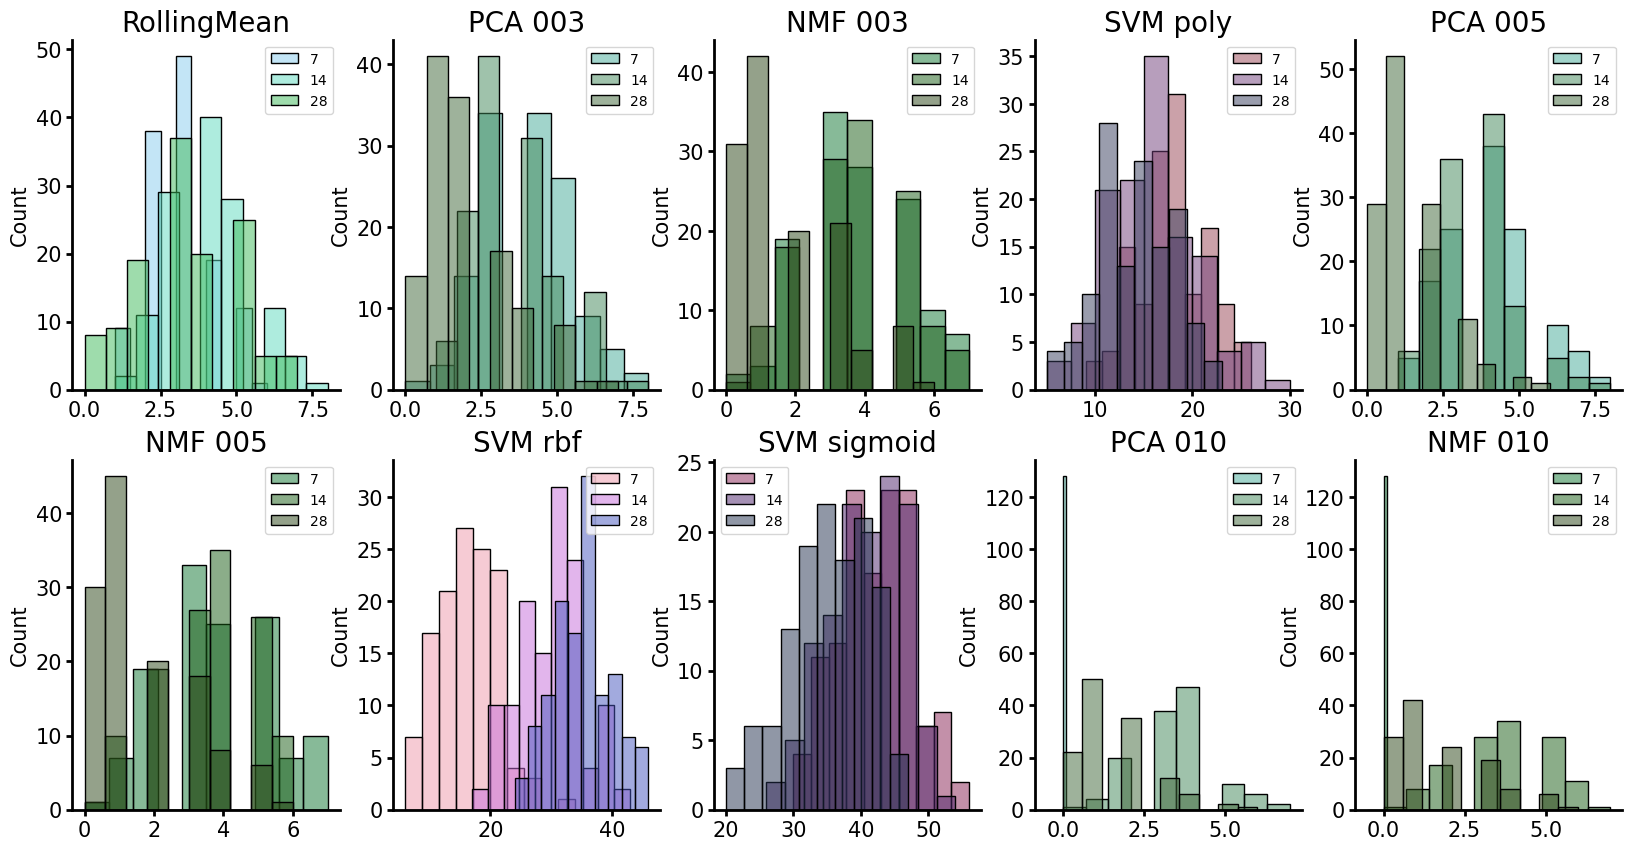

In [18]:
# Count detected anomalies per model-window_size
anoms = exp06_ad.groupby(['subject_id', 'window_size'])[anomaly_detector_cols].sum().reset_index()
fig, axes = plt.subplots(figsize=(20,10), nrows=2, ncols=5)
gray = Color("black")

for i, ad in enumerate(anomaly_detector_cols):
    ax = axes.flatten()[i]
    dname = ad.split('_anomaly')[0]
    base_c = Color(palette['model'][dname])
    p = list(base_c.range_to(gray, 7))
    for i, (ws, w_df) in enumerate(anoms.groupby('window_size')):
        sns.histplot(
            w_df[ad],
            color=p[i].hex_l,
            ax=ax,
            bins=10,
            alpha=.5,
            label=ws
        )
    ax.set_title(dname.replace('_', ' '), fontsize=20)
    ax.legend()
    ax.set_xlabel('')
    fa.despine_thicken_axes(ax, fontsize=15)


In [19]:
importlib.reload(anomaly_detection)
target = 'phq_stop'
phq_anomalies_qc = exp06_comb[
    (exp06_comb.days >= exp06_comb.period*6) & 
    (exp06_comb.days <= exp06_comb.period*8)
]
info_cols = [
    'subject_id',
    'period',
    #'window_size',
]
corr = anomaly_detection.correlateDetectedToOutcome(
    phq_anomalies_qc,
    anomaly_detector_cols,
    outcome_col=target,
    groupby_cols=info_cols,
)

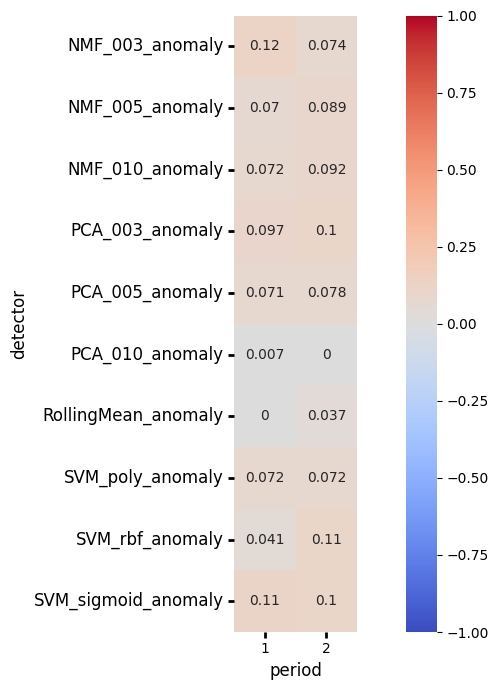

In [20]:

info_cols = [
    'period',
    'window_size',
]
for target in ['phq_stop']:
    corr['r2'] = corr['rho'] ** 2
    for metric in ['rho']:
        corr_table = corr.pivot_table(
            index=['detector'],
            columns=['period'],
            values='rho',
            aggfunc='median'
        )
        hm_size = (10, 7)
        fig, ax = plt.subplots(figsize=hm_size)
        sns.heatmap(
            corr_table,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            cmap='coolwarm',
            ax=ax
        )
        fa.despine_thicken_axes(ax, heatmap=True, fontsize=12, x_tick_fontsize=10)
        plt.tight_layout()

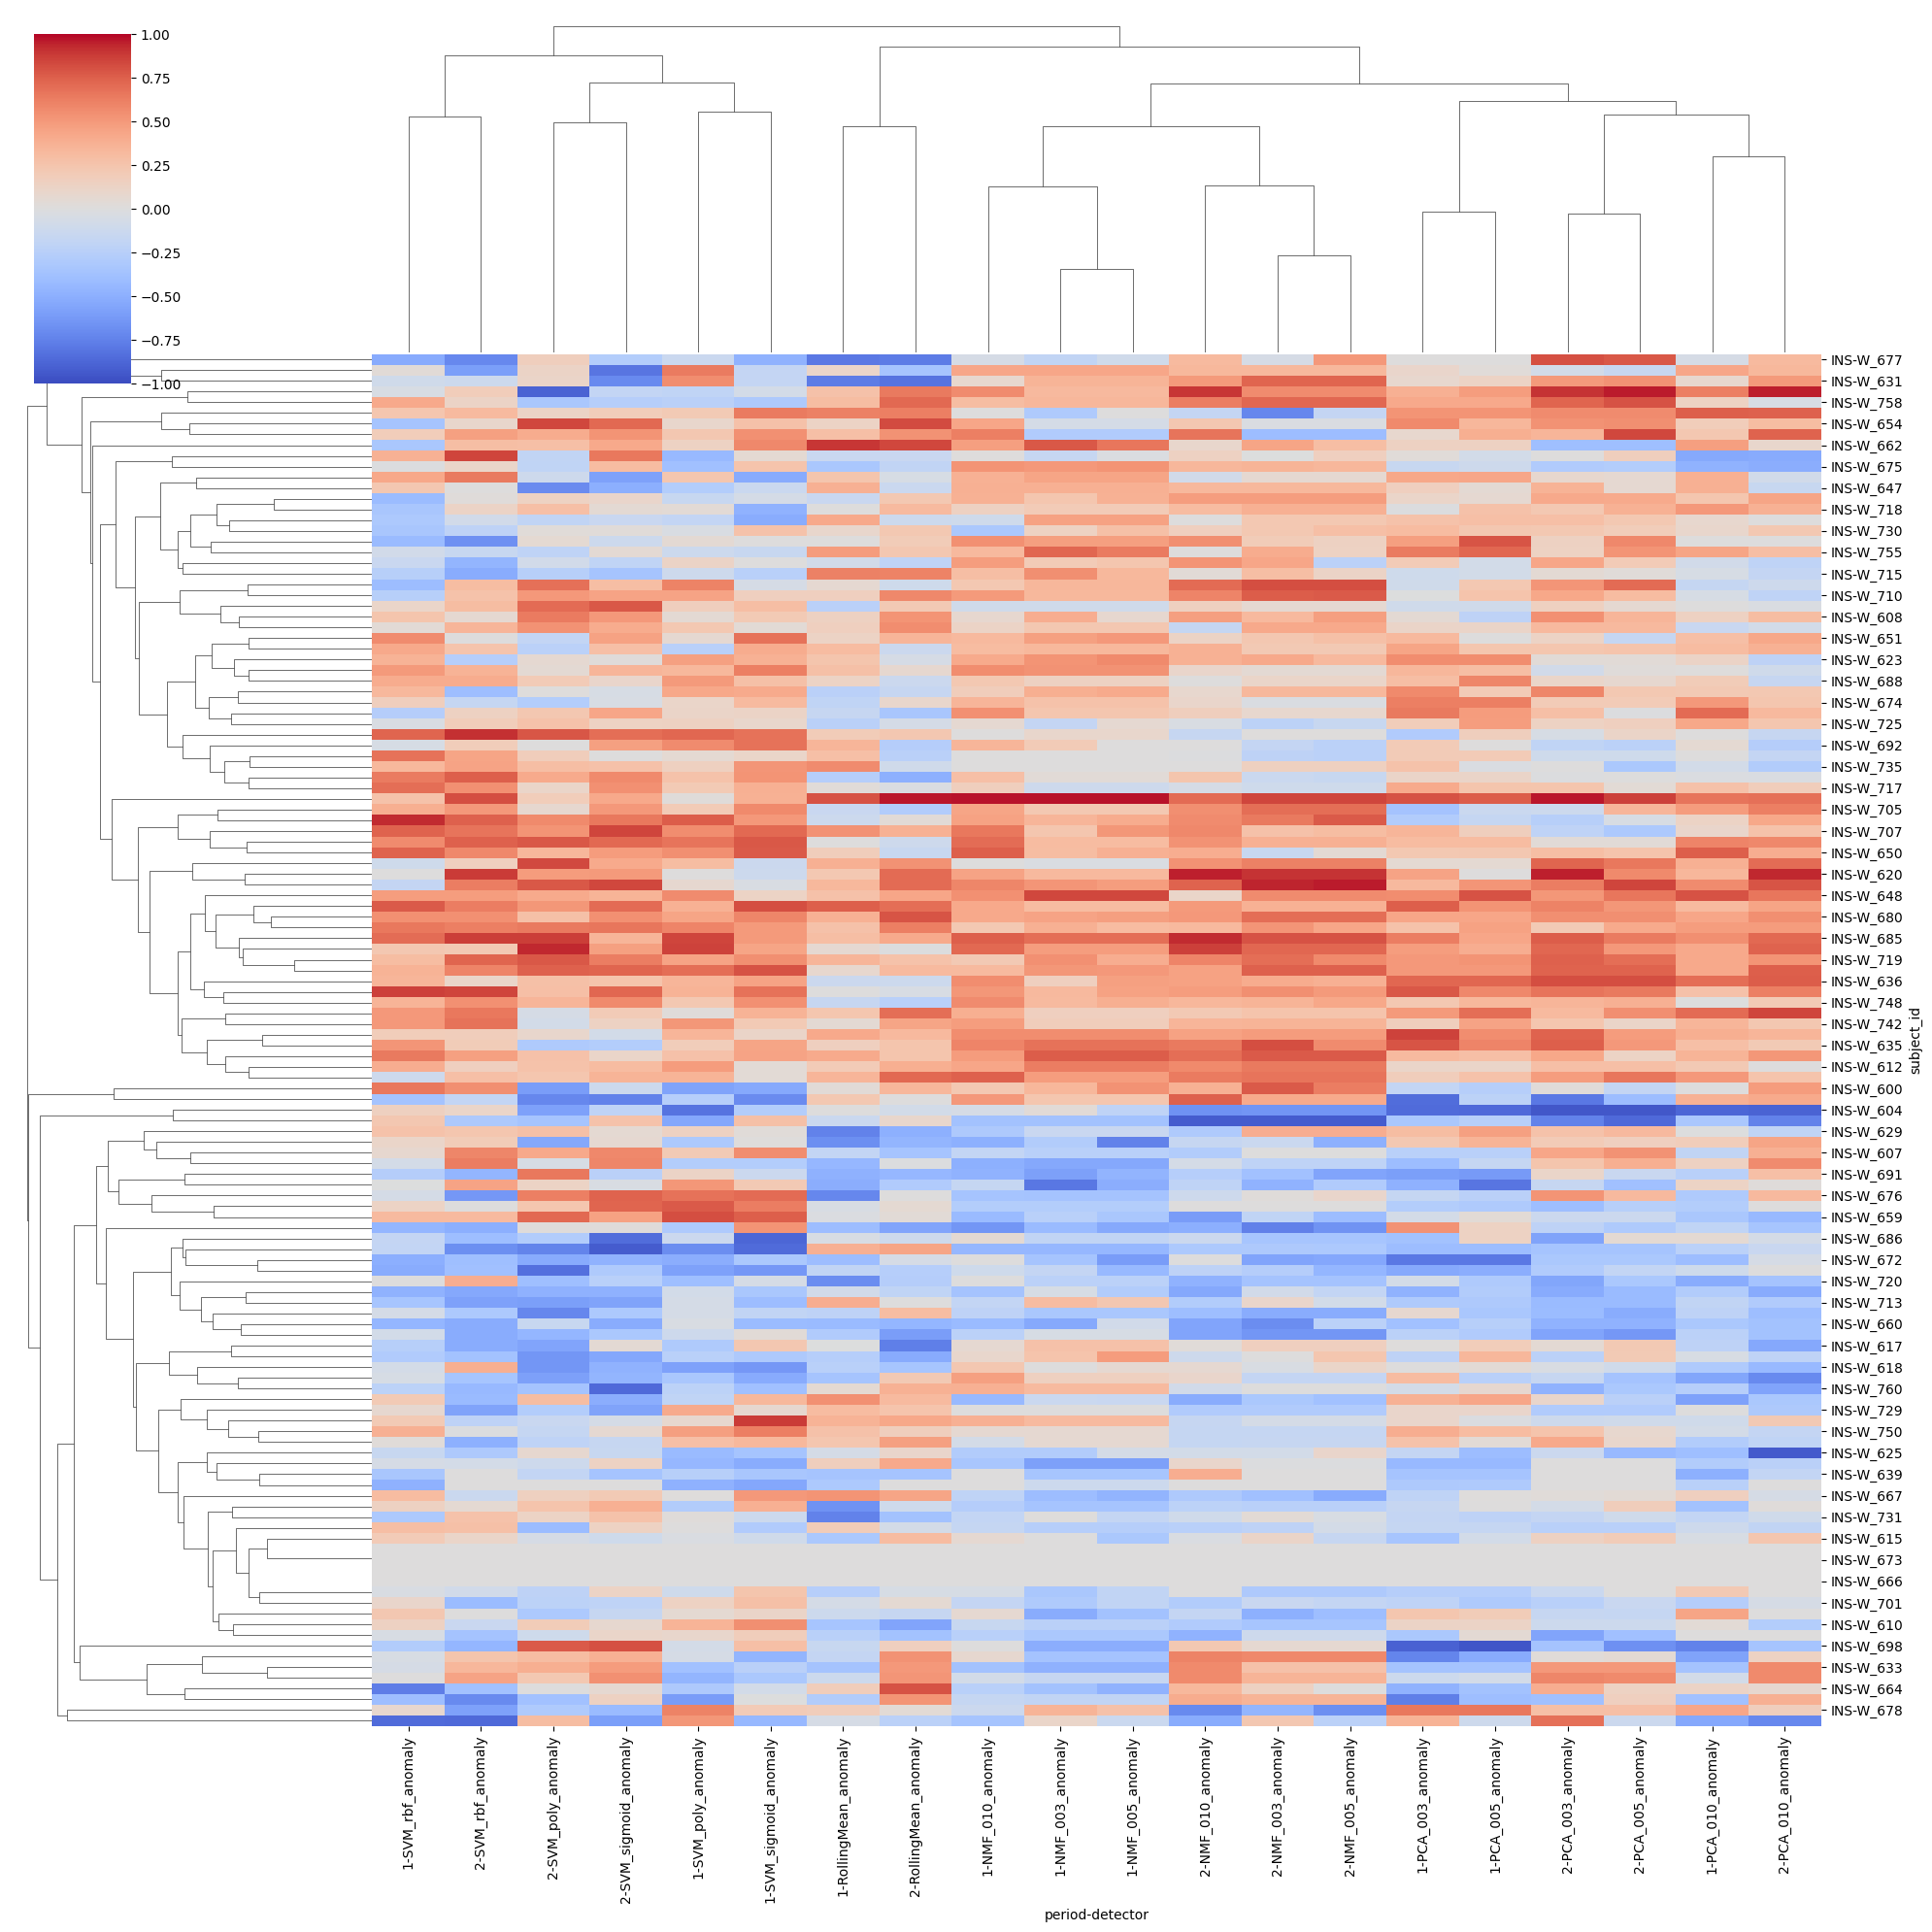

In [22]:
vals = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector'],
    values='rho',
)

anot = corr.pivot_table(
    index='subject_id',
    columns=['period', 'detector'],
    values='p',
)

anot = (anot < 0.05)

sns.clustermap(
    vals,
    #annot=anot,
    cmap='coolwarm',
    #col_cluster=False,
    vmin=-1,
    vmax=1,
    figsize=(20,20)
)

In [23]:
corr.period.nunique()

2

In [24]:
model_order = [
    'RollingMean',
    'PCA_003',
    'PCA_005',
    'PCA_010',
    'NMF_003',
    'NMF_005',
    'NMF_010',
    'SVM_rbf',
    'SVM_sigmoid',
    'SVM_poly',
]


In [25]:
l = .8
p_int = {
    m: Color(c)
    for m, c in palette['model'].items()

}
for m, c in p_int.items():
    c.set_luminance(l)

p_t= {
    m: c.get_hex_l()
    for m, c in p_int.items()
}

p_t

{'Linear Regression': '#c5cbd3',
 'Random Forest Regression': '#b0c0e8',
 'Gradient Boosting Regression': '#b7cde1',
 'Mixed Effects Random Forest': '#dcb7e1',
 'Baseline': '#cccccc',
 'Logistic Regression': '#c5cbd3',
 'Random Forest Classifier': '#b0c0e8',
 'Gradient Boosting Classifier': '#b7cde1',
 'PCA': '#b6e2db',
 'PCA_003': '#b6e2db',
 'PCA_005': '#b6e2db',
 'PCA_010': '#b6e2db',
 'PCA_020': '#b6e2db',
 'NMF': '#a6f2bf',
 'NMF_003': '#a6f2bf',
 'NMF_005': '#a6f2bf',
 'NMF_010': '#a6f2bf',
 'NMF_020': '#a6f2bf',
 'SVM': '#f0a8b6',
 'SVM_rbf': '#f0a8b6',
 'SVM_poly': '#e0b8c0',
 'SVM_sigmoid': '#ebadcc',
 'IsolationForest': '#ebe0ad',
 'RollingMean': '#a6d9f2'}

Text(0.5, 0, 'R-squared')

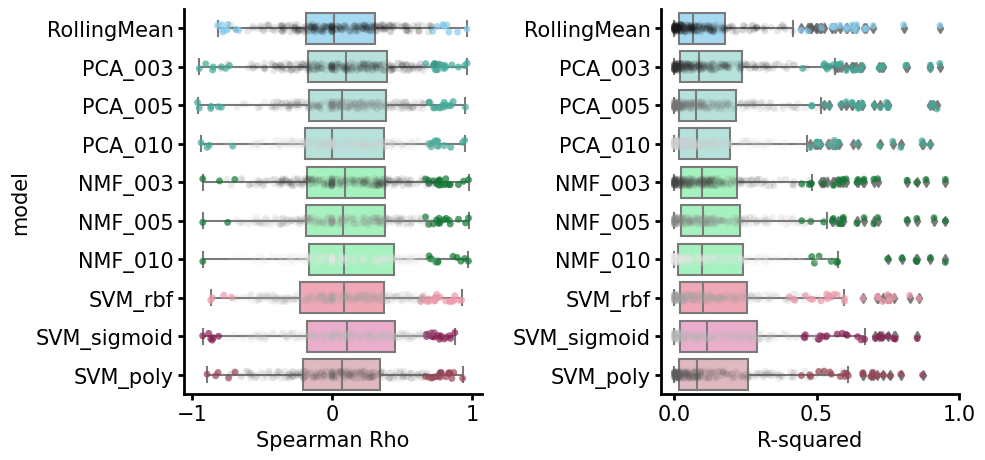

In [27]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=.6)
ns = corr[corr.p > 0.05]
sig = corr[corr.p < 0.05]
corr['model'] = corr['detector'].str.split('_anomaly').str[0]
p_transparent = {
    m: Color(c).get_rgb() for m, c in palette['model'].items()
}
for i, metric in enumerate(['rho', 'r2']):
    ax = axes[i]
    sns.stripplot(
        y='model',
        x=metric,
        data=sig,
        hue='model',
        palette=palette['model'],
        order=model_order,
        alpha=0.7,
        ax=ax
    )
    sns.stripplot(
        y='model',
        x=metric,
        data=ns,
        hue='model',
        palette='gray',
        order=model_order,
        alpha=0.1,
        ax=ax
    )
    sns.boxplot(
        y='model',
        x=metric,
        data=corr,
        hue='model',
        palette=p_t,
        #palette=palette['model'],
        #color='white',
        saturation=1,
        order=model_order,
        dodge=False,
        ax=ax
    )
    fa.despine_thicken_axes(ax, fontsize=15)
    ax.legend().remove()
    ax.set_xlabel('Spearman Rho')
ax.set_ylabel('')
ax.set_xlabel('R-squared')

In [28]:
sig_corr = corr[corr.p < 0.05]
sig_corr[sig_corr.period == 1].sort_values(by='rho').round(3)

,detector,rho,p,n,subject_id,period,r2,model
1564,PCA_005_anomaly,-0.961,0.001,7,INS-W_698,1,0.923,PCA_005
1561,PCA_003_anomaly,-0.902,0.005,7,INS-W_698,1,0.814,PCA_003
1447,SVM_sigmoid_anomaly,-0.881,0.002,9,INS-W_686,1,0.776,SVM_sigmoid
68,PCA_010_anomaly,-0.876,0.022,6,INS-W_604,1,0.768,PCA_010
64,PCA_005_anomaly,-0.867,0.025,6,INS-W_604,1,0.751,PCA_005
...,...,...,...,...,...,...,...,...
1060,RollingMean_anomaly,0.898,0.002,8,INS-W_662,1,0.806,RollingMean
2006,SVM_rbf_anomaly,0.927,0.001,8,INS-W_726,1,0.859,SVM_rbf
1949,NMF_010_anomaly,0.976,0.000,8,INS-W_723,1,0.952,NMF_010
1945,NMF_005_anomaly,0.976,0.000,8,INS-W_723,1,0.953,NMF_005


/var/folders/yl/t10bslz11cgdwwfk10mvyr1h0000gn/T/ipykernel_6416/2075002908.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_data[AD_col] = subject_data[AD_col].fillna(False)
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f] = pd.to_numeric(data[f], errors='coerce')
/Users/akre96/Code/dgc/mhealth_anomaly_detection/notebooks/../mhealth_anomaly_detection/plots.py:48: SettingWithCopyWarning: 
A v

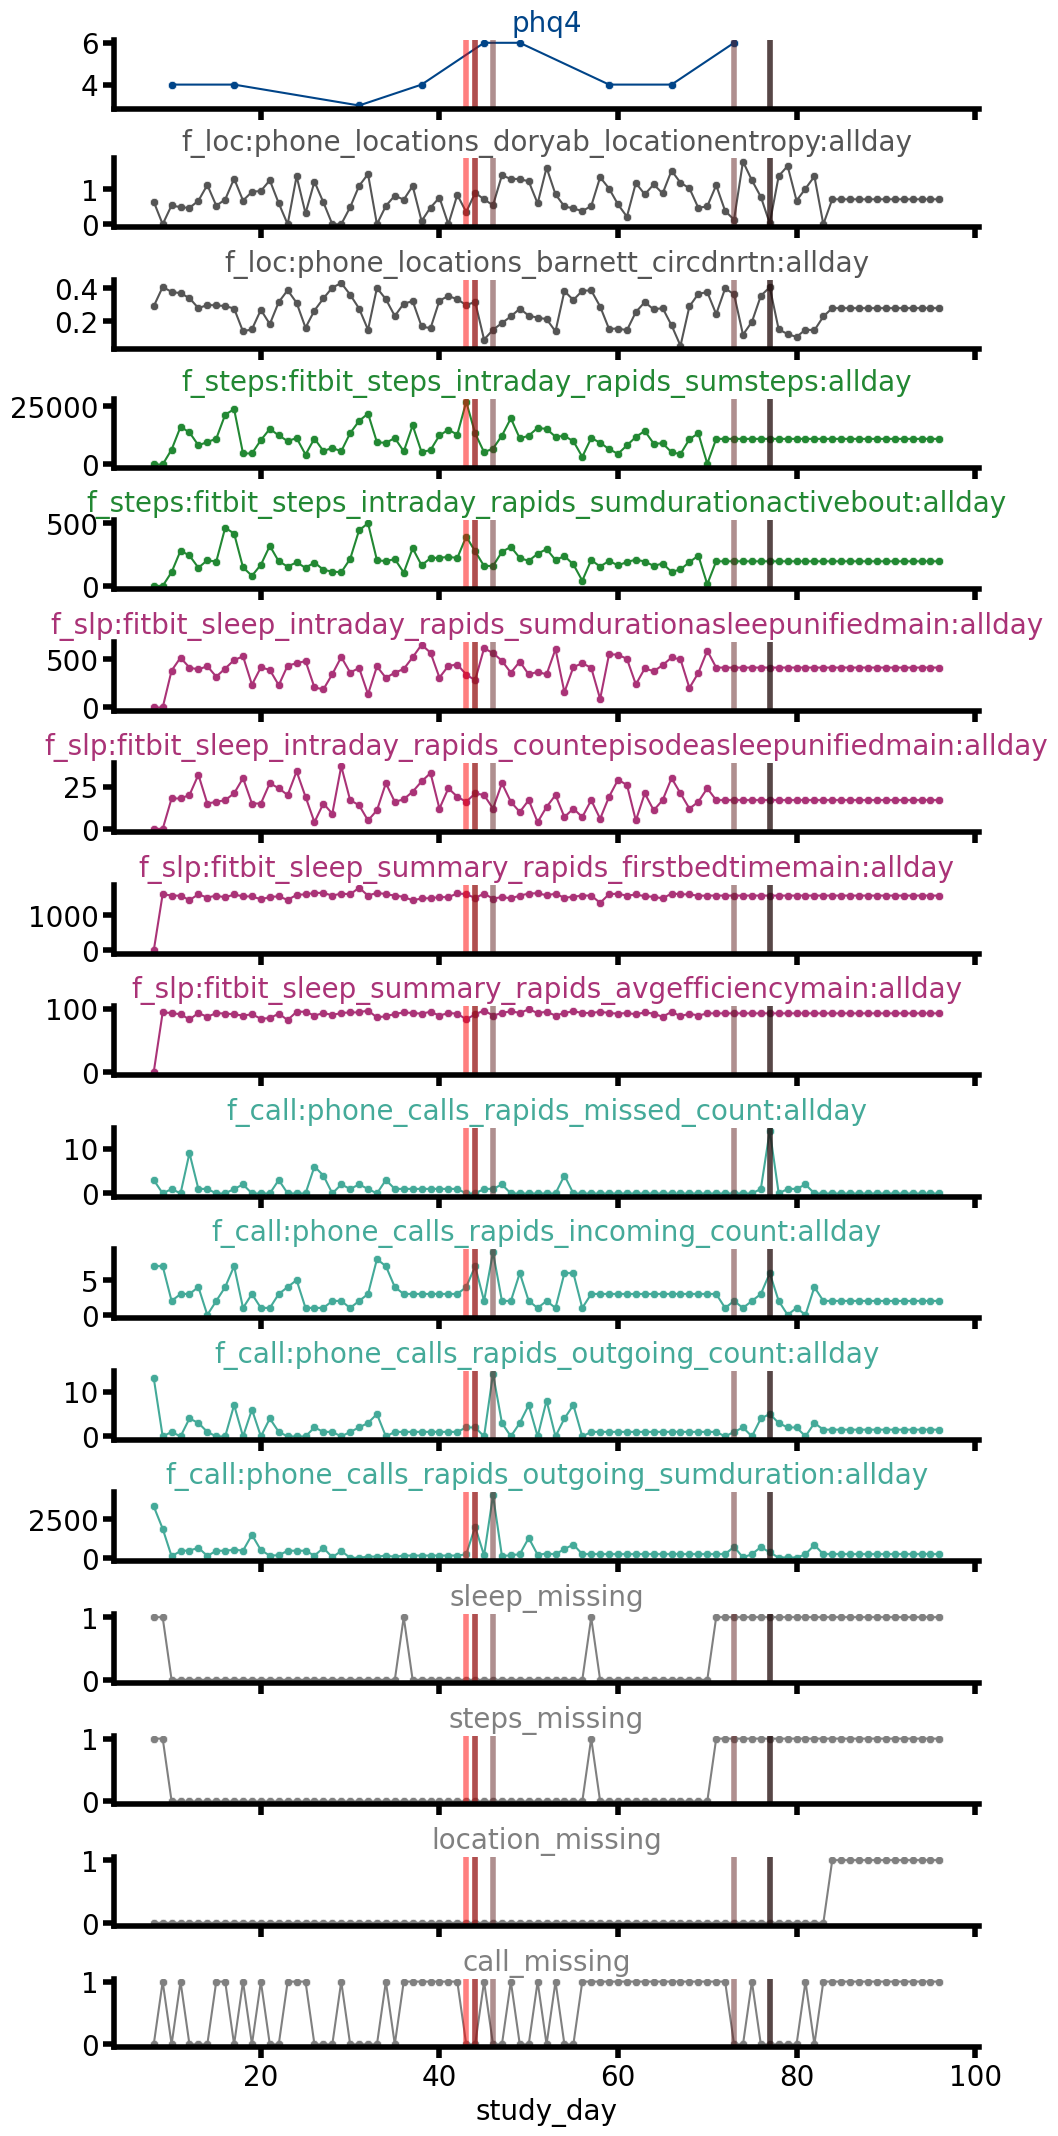

In [23]:
sid = 'INS-W_492'
AD_col = 'PCA_003_anomaly'
window_size = 7
features = [
    'f_loc:phone_locations_doryab_locationentropy:allday',
    'f_loc:phone_locations_barnett_circdnrtn:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumsteps:allday',
    'f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:allday',
    'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:allday',
    'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday',
    'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
    'f_call:phone_calls_rapids_missed_count:allday',
    'f_call:phone_calls_rapids_incoming_count:allday',
    'f_call:phone_calls_rapids_outgoing_count:allday',
    'f_call:phone_calls_rapids_outgoing_sumduration:allday',
    'sleep_missing',
    'steps_missing',
    'location_missing',
    'call_missing',
]
palette = lr.get_colors('../lib/colors.json')
subject_data = exp06_ad[
    (exp06_ad.subject_id == sid) &
    (exp06_ad.window_size == window_size)
]
subject_data[AD_col] = subject_data[AD_col].fillna(False)
_, axes = plots.lineplot_features(
    subject_data,
    plot_features=['phq4'] + features,
    scatter=True,
    palette=palette
)
pal = list(Color('red').range_to(Color('black'), 3))
for i, (ws, w_df) in enumerate(exp06_ad[exp06_ad.subject_id == sid].groupby('window_size')):
    ads = w_df[w_df[AD_col] == 1].study_day
    
    for ax in axes.flatten():
        ylims = ax.get_ylim()
        ax.vlines(ads, *ylims, color=pal[i].hex_l, lw=4, alpha=.5)
        ax.set_ylim(*ylims)
